In [1]:
# This script will import data from the LocalAir Escooter-based sensors.
# Data is encryped by the sensors, and this script decryptes before converting it into a pandas dataframe
# and then visualising it.
# Data can either be retrieved from a speificied folder, where all of the .bin files will be imported,
# or it can be downloaded directly from the website which the sensors uploads to. To avoid downloading
# files unnecceraily a time range can be specified.
# Behaviour is controlled through the "source" flag.

# importing the relevent libaries
from speck import SpeckCipher
import sys
import os

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import json

import pytz
from datetime import datetime

import urllib.request, urllib.error, urllib.parse

import numpy as np

import matplotlib.pyplot as plt

# some variables to control behvaiousr
pd.options.display.max_columns = None
# 'uploadFormat' is uesed to specify iif the file has come via being uplaoded, or if it is direct from
# the SD card. Something happens during the upload process that introduces a lot of new line charactors,
# and the software must get rid of these before it can process the file.
uploadFormat = True
numOfChunks = 60
source = 'Download' # can be 'Download' for downloading direclty of the web, 
                    # or 'Folder' for reading from a folder

# If you are working with files in a folder then this is the name of the directory where the files are stored
# if you have downloaded this off git you will need to change this!
directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/231023'

# if you are downloading them straight from https://london.localair.uk/ then you will need to specify the
# time range. These are the times between which we are going to download and process the files
# the datetime function takes variable in the format 'datetime'(YEAR, MONTH, DAY, HOUR, MINUTE)
download_start = datetime(2023, 10, 16, 0, 0)
download_end = datetime(2023, 10, 29, 0, 0)

In [2]:
# before converting to a data frame, all the data is going to go into a list of dicts, this list is called:
data = []

# and this is decode key for the spec incryption
key_string = '{0xad, 0x1c, 0x4b, 0x6, 0x5c, 0x85, 0x2a, 0x48, 0xe4, 0xed, 0x33, 0x23, 0x4c, 0x9f, 0xed, 0x56, 0x23, 0x46, 0x59, 0xfa, 0x3c, 0x70, 0x82, 0x97, 0x45, 0xbd, 0x2b, 0xf1, 0xdc, 0xf4, 0xb6, 0xce}'

# the key string format above is how the teensy needs in, we convert it into an int for python thusly:
# we can convert into somethign this code can use by doing this:
key = [int(i,16) for i in key_string[1:-1].split(',')]

# and now with the key we can set up our Speck Decryptre
my_speck = SpeckCipher(int.from_bytes(bytes(key), byteorder='big'), key_size=256, block_size=128)

In [3]:
# A function to converting the slightly funny GPS lat and long format into decimalised degrees.
def ddmm_to_degrees(ddmm):
    degrees, minutes = ddmm.astype('float64').divmod(100)
    return (degrees + minutes/60)

# a functionf or getting rid of the '-' values which appear when the GPS hasn't got a fix.
def missing_data(series):
    return series == '-'

In [4]:
# This is the code we run when we are checking a specific folder.
if source == 'Folder':
    # to manage folder in a operating system agnostic way it is best to use the 'os' libary.
    # here we are turning the string in which the direactory was given into some more agnostic.
    directory = os.fsencode(directory_in_str)

    # we are going to iterate through the files in that directory
    for fileBytes in os.listdir(directory):
        # get the name of the file, to see if it has the correct extention 
        filename = os.fsdecode(fileBytes)
        # and if it does, we process it
        if filename.endswith(".bin"):
            print('Checking {}'.format(filename))
            # open the file
            with open(os.path.join(directory, fileBytes), 'r') as file:
                # we are going to keep track of the line we are on, just for the perpose of error messages.
                line_count = 0
                # go through the file line by line
                for line in file:
                    # check the line isn't blank
                    if line == '\n':
                        # skip it if is.
                        continue
                    if uploadFormat:
                        # this means that the file is in the funny format that you seem to get when
                        # uploading via Strings from the sensor to James's server. We have to convert 
                        # it into the normal format
                        while True:
                            line_part = file.readline()
                            if (line_part == '\n' or line_part == ''):
                                break
                            line = line.strip() + line_part.strip();
                    # we need a line encramter so that we can tell the user where there are errors
                    line_count = line_count + 1
                    # and this is going to be the string into which we save the decoded ascii
                    DecodedAsciiLine = ''

                    # each line is encoded into a number of encoded chunks, at the moment that number is 60,
                    # although it might change so I've put it in a variable.
                    for i in range(numOfChunks):
                        encChunk = line[i*32:(i*32)+32]
                        try:
                            CipherTextChunk = int(encChunk, 16)
                        except ValueError:
                            # the data we dealing with is rarely perfect, but least becasue the micro controller
                            # on sensor will always encrypt the same length of memory, even if the data does not
                            # fill it completely, this means there is almost always some random jibberish at the
                            # end. For reason almost all of this part of the processing is encased in tries.
                            # it is give it a go, and if it doesn't work it will output an error message and
                            # carry on with its day. It might be possible to do more to recover data that is 
                            # corrupted, but I haven't tried to do this yet.
                            print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                                # NOTE:'file=sys.stderr' means the message appears as an Error on a UNIX based OS
                                # I DON'T KNOW IF THIS WORKS ON WINDOWS... PROBABLY NOT. 
                                # this is the case for all of the tries in the below code.
                        PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                        # now decode the hex to ascii

                        try:
                            # convert to a byte array
                            # we cut off the first two characters because they are the '0x' signifing hex
                            PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                        except ValueError:
                            print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                        # each line ends with guff, so we have to look out for the null byte,
                        # which signifies the end.
                        # look for the null character
                        nullLoc = PlaneByteArray.find(b'\00')

                        # if the location returned is 0 or higher then there is a null character in there
                        # and we must ignore everything after it
                        if (nullLoc > -1):
                            try:
                                # This turns the int value that is returned by the decruption into an ascii
                                # array.
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        else:
                            try:
                                # if there was no null char then we do the whole string
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        # and concat the new block onto the exisiting string
                        DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                        # if we found the null character then we have reached the end of the message and can 
                        # break the loop
                        if (nullLoc > -1):
                            break
                    # now we are going to try and decode the json string and convert it into a nested data structure
                    try:
                        data.append(json.loads(DecodedAsciiLine.strip()))
                    except ValueError:
                        # if it doesn't work, then try and output it.
                        print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                              file=sys.stderr
                             )
                continue
        else:
            continue

In [5]:
# This is the code we run if we are getting stuff directly from the website.
if source == 'Download':
    # specify the base link to the data.
    url = 'https://london.localair.uk/data/archive/'

    # make the request to that URL
    response = urllib.request.urlopen(url)

    # decode the responce to UTF-8. This is the form of HTML, which then needs some working with to get the
    # file names we are interested in.
    wc = response.read().decode('UTF-8')

    # we are going to create a dataframe of the files that are available, this will include the name and
    # the timestamp that that signfies. The two lists below are populated before being turned into a 
    # dataframe.
    fileName = []
    timestamp = []

    # split the responce into a list deliniated by double quotes and iteraate through it
    for i in wc.split('"'):
        # if this item ends with the characters '.bin' then it is a filename and we save it to our list.
        if i[-4:] == '.bin':
            fileName.append(i)
            # the file name is simply a timestamp with a '.bin' ending. We covert that into a datetime variable
            # and save that into the other list.
            timestamp.append(datetime.strptime(i, '%Y%m%d_%H%M%S_%f.bin'))
    
    # create the data frame.
    df_files = pd.DataFrame({'FileName':fileName, 'TimeStamp': timestamp})

    # no we mask out those files that are outside our specified range.
    mask = (df_files['TimeStamp'] > download_start) & (df_files['TimeStamp'] < download_end)
    
    # print a list of the file.
    print(df_files['TimeStamp'])
    
    # for through all the files that are in the time range.
    for file in df_files[mask]['FileName']:
        filename = file
        # download the file
        response = urllib.request.urlopen(url+file)
        # decode the file into utf-8
        wc = response.read().decode('UTF-8')
        line_count = 0
        # we process it in much the same way as we did with the files in a folder.
        # Although there are some differences as we now have to remove '\n' characters. Again, thismight
        # be different on windows.
        for line in wc.split('\n\n'):
            if line == '':
                continue
            line = line.replace('\n', "")
            # From here on in I think it's essentially the same as the cell above.
            # we need a line encramter so that we can tell the user where there are errors
            line_count = line_count + 1
            # and this is going to be the string into which we save the decoded ascii
            DecodedAsciiLine = ''

            # each line is encoded into a number of encoded chunks, at the moment that number is 60,
            # although it might change so I've put it in a variable.
            for i in range(numOfChunks):
                encChunk = line[i*32:(i*32)+32]
                try:
                    CipherTextChunk = int(encChunk, 16)
                except ValueError:
                    print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                # now decode the hex to ascii

                # so the message ends with guff, so we have to look out for the nulll byte,
                # which signifies the end.
                # convert to a byte array
                # we cut off the first two characters because they are the '0x' signifing hex
                try:
                    PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                except ValueError:
                    print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                    AsciiChunk = ''
                # look for the null character
                nullLoc = PlaneByteArray.find(b'\00')

                # if the location returned is 0 or higher then there is a null character in there
                # and we must ignore everything after it
                if (nullLoc > -1):
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                else:
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                # and concat the new block onto the exisiting string
                DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                # if we found the null character then we have reached the end of the message and can 
                # break the loop
                if (nullLoc > -1):
                    break
            # now we are going to try and decode the json string and convert it into a nested data structure
            try:
                data.append(json.loads(DecodedAsciiLine.strip()))
            except ValueError:
                # if it doesn't work, then try and output it.
                print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                      file=sys.stderr
                     )
        continue

0     2023-09-07 14:42:43.984000
1     2023-09-07 16:24:35.560600
2     2023-09-07 16:29:50.711600
3     2023-09-07 16:31:50.473200
4     2023-09-07 16:33:43.830600
                 ...            
341   2023-10-28 12:44:27.818800
342   2023-10-28 12:46:27.990600
343   2023-10-28 12:48:24.705400
344   2023-10-28 12:50:25.031600
345   2023-10-28 12:52:28.482400
Name: TimeStamp, Length: 346, dtype: datetime64[ns]


Could not convert to int in 20231016_145831_5791.bin, line 1, chunk 0, could not decrypt
Error Decoding JSON in 20231016_145831_5791.bin, on line 1
Error Decoding JSON in 20231016_150818_4419.bin, on line 1
Error in 20231016_162434_1232.bin, line 1, chunk 0, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 1, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 1, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 2, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 2, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 3, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 3, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 4, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 4, count not convert to ascii
Could not convert to int in 20231016_16243

Error Decoding JSON in 20231017_115229_9895.bin, on line 1
Error Decoding JSON in 20231017_115229_9895.bin, on line 6
Error in 20231017_115245_3168.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115245_3168.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_115245_3168.bin, chunk 1, could not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_115245_3168.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_115245_3168.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_115245_3168.bin, line 3, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115245_3168.bin, chunk 3, could no

Error in 20231017_115606_7641.bin, line 6, chunk 32, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 33, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115606_7641.bin, chunk 6, could not decrypt
Non-Hex Value found in line 20231017_115606_7641.bin, chunk 6, could not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 36, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 37, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 38, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 39, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 40, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 41, count not convert to ascii
Error in 20231017_115606_7641.bin, line 6, chunk 42, count not convert to ascii
Error in 20231017_115606_7641

Error Decoding JSON in 20231017_115627_6832.bin, on line 1
Error Decoding JSON in 20231017_115627_6832.bin, on line 6
Error in 20231017_115644_3061.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115644_3061.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_115644_3061.bin, chunk 1, could not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_115644_3061.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_115644_3061.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_115644_3061.bin, line 3, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115644_3061.bin, chunk 3, could no

Error in 20231017_120500_6801.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_120500_6801.bin, chunk 2, could not decrypt
Non-Hex Value found in line 20231017_120500_6801.bin, chunk 2, could not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 36, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 37, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 38, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 39, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 40, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 41, count not convert to ascii
Error in 20231017_120500_6801.bin, line 2, chunk 42, count not convert to ascii
Error in 20231017_120500_6801

Error in 20231017_121129_2964.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_121129_2964.bin, chunk 2, could not decrypt
Non-Hex Value found in line 20231017_121129_2964.bin, chunk 2, could not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 36, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 37, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 38, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 39, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 40, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 41, count not convert to ascii
Error in 20231017_121129_2964.bin, line 2, chunk 42, count not convert to ascii
Error in 20231017_121129_2964

Error in 20231017_121732_1064.bin, line 26, chunk 32, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 33, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_121732_1064.bin, chunk 26, could not decrypt
Non-Hex Value found in line 20231017_121732_1064.bin, chunk 26, could not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 36, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 37, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 38, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 39, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 40, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 41, count not convert to ascii
Error in 20231017_121732_1064.bin, line 26, chunk 42, count not convert to ascii
Error in 20231017

Error in 20231017_141916_2477.bin, line 6, chunk 32, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 33, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_141916_2477.bin, chunk 6, could not decrypt
Non-Hex Value found in line 20231017_141916_2477.bin, chunk 6, could not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 36, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 37, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 38, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 39, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 40, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 41, count not convert to ascii
Error in 20231017_141916_2477.bin, line 6, chunk 42, count not convert to ascii
Error in 20231017_141916_2477

Error in 20231017_145308_1832.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145308_1832.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_145308_1832.bin, chunk 1, could not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 38, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 39, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 40, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 41, count not convert to ascii
Error in 20231017_145308_1832.bin, line 1, chunk 42, count not convert to ascii
Error in 20231017_145308_1832

Error in 20231017_145339_7202.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 1, could not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_145339_7202.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_145339_7202.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_145339_7202.bin, line 3, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 3, could not decrypt
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 3, could not convert to ascii
Error in 20231017_

Error in 20231017_145428_8665.bin, line 253, chunk 32, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 33, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145428_8665.bin, chunk 253, could not decrypt
Non-Hex Value found in line 20231017_145428_8665.bin, chunk 253, could not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 36, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 37, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 38, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 39, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 40, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 41, count not convert to ascii
Error in 20231017_145428_8665.bin, line 253, chunk 42, count not convert to ascii
Error

Error in 20231017_145440_5866.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 1, could not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_145440_5866.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_145440_5866.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_145440_5866.bin, line 2, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 2, could not decrypt
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 2, could not convert to ascii
Error in 20231017_

Error Decoding JSON in 20231017_145523_6721.bin, on line 2
Error Decoding JSON in 20231017_145531_2725.bin, on line 5
Error Decoding JSON in 20231017_145531_2725.bin, on line 6
Error Decoding JSON in 20231017_145531_2725.bin, on line 7
Error Decoding JSON in 20231017_145531_2725.bin, on line 9
Error Decoding JSON in 20231017_145538_0085.bin, on line 3
Error Decoding JSON in 20231017_145538_0085.bin, on line 4
Error in 20231017_145538_0085.bin, line 12, chunk 32, count not convert to ascii
Error in 20231017_145538_0085.bin, line 12, chunk 33, count not convert to ascii
Error in 20231017_145538_0085.bin, line 12, chunk 34, count not convert to ascii
Error in 20231017_145545_7711.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_145545_7711.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_145545_7711.bin, line 1, chunk 34, count not convert to ascii
Error in 20231017_145545_7711.bin, line 1, chunk 35, count not convert to ascii
Error in 20231017_145545

Error in 20231017_154842_4059.bin, line 5, chunk 32, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 33, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 34, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 35, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 36, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 37, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 38, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 39, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 40, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 41, count not convert to ascii
Error in 20231017_154842_4059.bin, line 5, chunk 42, count not convert to ascii
Error in 20231017_154842_4059.bin, line 7, chunk 32, count not convert to ascii
Error in 20231017_154842_4059.bin, line 

Error in 20231017_155639_1651.bin, line 5, chunk 32, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 33, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 34, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 35, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 36, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 37, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 38, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 39, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 40, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 41, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 42, count not convert to ascii
Error in 20231017_155639_1651.bin, line 5, chunk 43, count not convert to ascii
Error in 20231017_155639_1651.bin, line 

Error in 20231017_161439_3771.bin, line 8, chunk 32, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 33, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 34, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 35, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 36, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 37, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 38, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 39, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 40, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 41, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 42, count not convert to ascii
Error in 20231017_161439_3771.bin, line 8, chunk 43, count not convert to ascii
Error in 20231017_161439_3771.bin, line 

Error in 20231017_163043_1754.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 34, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 35, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 36, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 37, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 38, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 39, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 40, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 41, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 42, count not convert to ascii
Error in 20231017_163043_1754.bin, line 3, chunk 43, count not convert to ascii
Error in 20231017_163043_1754.bin, line 

Error in 20231017_163842_4991.bin, line 8, chunk 32, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 33, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 34, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 35, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 36, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 37, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 38, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 39, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 40, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 41, count not convert to ascii
Error in 20231017_163842_4991.bin, line 8, chunk 42, count not convert to ascii
Error in 20231017_164040_9161.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_164040_9161.bin, line 

Error in 20231017_165841_2593.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 34, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 35, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 36, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 37, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 38, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 39, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 40, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 41, count not convert to ascii
Error in 20231017_165841_2593.bin, line 3, chunk 42, count not convert to ascii
Error in 20231017_165841_2593.bin, line 8, chunk 32, count not convert to ascii
Error in 20231017_165841_2593.bin, line 

Error in 20231018_170841_1277.bin, line 3, chunk 32, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 33, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 34, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 35, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 36, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 37, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 38, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 39, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 40, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 41, count not convert to ascii
Error in 20231018_170841_1277.bin, line 3, chunk 42, count not convert to ascii
Error in 20231018_170841_1277.bin, line 5, chunk 32, count not convert to ascii
Error in 20231018_170841_1277.bin, line 

Error Decoding JSON in 20231018_175821_2340.bin, on line 21
Error in 20231018_175821_2340.bin, line 38, chunk 35, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 36, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 37, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 38, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 39, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 40, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 41, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 42, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 43, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 44, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 45, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk

Error Decoding JSON in 20231018_175845_6855.bin, on line 83
Error Decoding JSON in 20231018_175845_6855.bin, on line 104
Error Decoding JSON in 20231018_175845_6855.bin, on line 107
Error Decoding JSON in 20231018_175845_6855.bin, on line 136
Error Decoding JSON in 20231018_175845_6855.bin, on line 144
Error in 20231018_223227_7735.bin, line 1, chunk 33, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 34, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 35, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 36, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 37, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 38, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 39, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 40, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 41, cou

Error Decoding JSON in 20231019_092702_2452.bin, on line 5
Error Decoding JSON in 20231019_092702_2452.bin, on line 11
Error Decoding JSON in 20231019_092702_2452.bin, on line 20
Error Decoding JSON in 20231019_092702_2452.bin, on line 33
Error Decoding JSON in 20231019_092702_2452.bin, on line 34
Error Decoding JSON in 20231019_092702_2452.bin, on line 43
Error Decoding JSON in 20231019_092702_2452.bin, on line 47
Error Decoding JSON in 20231019_092702_2452.bin, on line 49
Error Decoding JSON in 20231019_092702_2452.bin, on line 51
Error Decoding JSON in 20231019_092702_2452.bin, on line 52
Error Decoding JSON in 20231019_092702_2452.bin, on line 54
Error Decoding JSON in 20231019_092702_2452.bin, on line 60
Error in 20231019_092702_2452.bin, line 76, chunk 22, count not convert to ascii
Could not convert to int in 20231019_092702_2452.bin, line 76, chunk 23, could not decrypt
Error in 20231019_092702_2452.bin, line 76, chunk 23, count not convert to ascii
Could not convert to int in 

Error Decoding JSON in 20231020_092004_8534.bin, on line 43
Error Decoding JSON in 20231020_092004_8534.bin, on line 47
Error Decoding JSON in 20231020_092004_8534.bin, on line 118
Error Decoding JSON in 20231020_092004_8534.bin, on line 119
Error Decoding JSON in 20231020_092004_8534.bin, on line 129
Error Decoding JSON in 20231020_092004_8534.bin, on line 138
Error Decoding JSON in 20231020_092004_8534.bin, on line 153
Error Decoding JSON in 20231020_092004_8534.bin, on line 160
Error Decoding JSON in 20231020_092004_8534.bin, on line 175
Error Decoding JSON in 20231020_092004_8534.bin, on line 244
Error Decoding JSON in 20231020_092004_8534.bin, on line 250
Error Decoding JSON in 20231020_092004_8534.bin, on line 252
Error Decoding JSON in 20231020_092004_8534.bin, on line 273
Error Decoding JSON in 20231020_092004_8534.bin, on line 274
Error in 20231020_092004_8534.bin, line 319, chunk 20, count not convert to ascii
Could not convert to int in 20231020_092004_8534.bin, line 319, ch

Error in 20231020_092229_1696.bin, line 12, chunk 34, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 35, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 36, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 37, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 38, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 39, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 40, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 41, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 42, count not convert to ascii
Error in 20231020_092229_1696.bin, line 12, chunk 43, count not convert to ascii
Error Decoding JSON in 20231020_172549_0344.bin, on line 55
Error Decoding JSON in 20231020_172549_0344.bin, on line 76
Error Decoding JSON in 20231020_172549_0344.bin, on line 91
Error Deco

Error Decoding JSON in 20231020_172637_0889.bin, on line 8
Error Decoding JSON in 20231020_172637_0889.bin, on line 46
Error Decoding JSON in 20231020_172637_0889.bin, on line 53
Error Decoding JSON in 20231020_172637_0889.bin, on line 76
Error Decoding JSON in 20231020_172637_0889.bin, on line 78
Error Decoding JSON in 20231020_172637_0889.bin, on line 84
Error in 20231020_172637_0889.bin, line 103, chunk 8, count not convert to ascii
Could not convert to int in 20231020_172637_0889.bin, line 103, chunk 9, could not decrypt
Error in 20231020_172637_0889.bin, line 103, chunk 9, count not convert to ascii
Could not convert to int in 20231020_172637_0889.bin, line 103, chunk 10, could not decrypt
Error in 20231020_172637_0889.bin, line 103, chunk 10, count not convert to ascii
Could not convert to int in 20231020_172637_0889.bin, line 103, chunk 11, could not decrypt
Error in 20231020_172637_0889.bin, line 103, chunk 11, count not convert to ascii
Could not convert to int in 20231020_172

Error Decoding JSON in 20231020_172659_6547.bin, on line 71
Error Decoding JSON in 20231020_172659_6547.bin, on line 72
Error Decoding JSON in 20231020_172659_6547.bin, on line 112
Error Decoding JSON in 20231020_172659_6547.bin, on line 114
Error Decoding JSON in 20231020_172659_6547.bin, on line 115
Error in 20231020_172659_6547.bin, line 116, chunk 2, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 3, could not decrypt
Error in 20231020_172659_6547.bin, line 116, chunk 3, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 4, could not decrypt
Error in 20231020_172659_6547.bin, line 116, chunk 4, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 5, could not decrypt
Error in 20231020_172659_6547.bin, line 116, chunk 5, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 6, could not decrypt
Error in 

Error Decoding JSON in 20231020_172727_0468.bin, on line 28
Error Decoding JSON in 20231020_172727_0468.bin, on line 31
Error Decoding JSON in 20231020_172727_0468.bin, on line 41
Error in 20231020_172727_0468.bin, line 61, chunk 29, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 30, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 30, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 31, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 31, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 32, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 32, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 33, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 33, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bi

Error Decoding JSON in 20231020_172817_6393.bin, on line 11
Error Decoding JSON in 20231020_172817_6393.bin, on line 150
Error Decoding JSON in 20231020_172817_6393.bin, on line 151
Error Decoding JSON in 20231020_172817_6393.bin, on line 154
Error Decoding JSON in 20231020_172817_6393.bin, on line 212
Error in 20231020_172817_6393.bin, line 236, chunk 2, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 3, could not decrypt
Error in 20231020_172817_6393.bin, line 236, chunk 3, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 4, could not decrypt
Error in 20231020_172817_6393.bin, line 236, chunk 4, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 5, could not decrypt
Error in 20231020_172817_6393.bin, line 236, chunk 5, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 6, could not decrypt
Error in

Error Decoding JSON in 20231020_172835_4559.bin, on line 6
Error in 20231020_172835_4559.bin, line 39, chunk 35, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 36, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 37, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 38, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 39, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 40, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 41, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 42, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 43, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 44, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 45, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 

Error Decoding JSON in 20231023_175911_4184.bin, on line 3
Error Decoding JSON in 20231023_175911_4184.bin, on line 24
Error Decoding JSON in 20231023_175911_4184.bin, on line 58
Error Decoding JSON in 20231023_175911_4184.bin, on line 67
Error Decoding JSON in 20231023_175911_4184.bin, on line 81
Error Decoding JSON in 20231023_175911_4184.bin, on line 102
Error in 20231023_175911_4184.bin, line 108, chunk 36, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 37, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 38, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 39, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 40, count not convert to ascii
Error Decoding JSON in 20231023_175911_4184.bin, on line 140
Error Decoding JSON in 20231023_175911_4184.bin, on line 146
Error Decoding JSON in 20231023_175911_4184.bin, on line 149
Error Decoding JSON in 20231023_175911_4184.bin

Error Decoding JSON in 20231023_175941_8422.bin, on line 4
Error Decoding JSON in 20231023_175941_8422.bin, on line 6
Error Decoding JSON in 20231023_175941_8422.bin, on line 59
Error in 20231023_175941_8422.bin, line 62, chunk 29, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 30, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 30, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 31, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 31, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 32, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 32, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 33, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 33, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin,

Error Decoding JSON in 20231023_180022_7303.bin, on line 16
Error Decoding JSON in 20231023_180022_7303.bin, on line 26
Error in 20231023_180022_7303.bin, line 37, chunk 34, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 35, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 36, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 37, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 38, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 39, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 40, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 41, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 42, count not convert to ascii
Error in 20231023_180022_7303.bin, line 37, chunk 43, count not convert to ascii
Error Decoding JSON in 20231023_180022_7303.bin, on line 39
Error Deco

Error Decoding JSON in 20231023_180050_6559.bin, on line 16
Error Decoding JSON in 20231023_180050_6559.bin, on line 24
Error Decoding JSON in 20231023_180050_6559.bin, on line 27
Error Decoding JSON in 20231023_180050_6559.bin, on line 33
Error Decoding JSON in 20231023_180050_6559.bin, on line 45
Error in 20231023_180050_6559.bin, line 61, chunk 29, count not convert to ascii
Could not convert to int in 20231023_180050_6559.bin, line 61, chunk 30, could not decrypt
Error in 20231023_180050_6559.bin, line 61, chunk 30, count not convert to ascii
Could not convert to int in 20231023_180050_6559.bin, line 61, chunk 31, could not decrypt
Error in 20231023_180050_6559.bin, line 61, chunk 31, count not convert to ascii
Could not convert to int in 20231023_180050_6559.bin, line 61, chunk 32, could not decrypt
Error in 20231023_180050_6559.bin, line 61, chunk 32, count not convert to ascii
Could not convert to int in 20231023_180050_6559.bin, line 61, chunk 33, could not decrypt
Error in 202

Error in 20231023_180118_3458.bin, line 7, chunk 34, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 35, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 36, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 37, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 38, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 39, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 40, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 41, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 42, count not convert to ascii
Error in 20231023_180118_3458.bin, line 7, chunk 43, count not convert to ascii
Error Decoding JSON in 20231023_180118_3458.bin, on line 10
Error Decoding JSON in 20231023_180118_3458.bin, on line 11
Error in 20231023_180118_3458.bin, line 61, chunk 29, count not convert to ascii

Error Decoding JSON in 20231023_180210_8439.bin, on line 6
Error Decoding JSON in 20231023_180210_8439.bin, on line 14
Error Decoding JSON in 20231023_180210_8439.bin, on line 18
Error Decoding JSON in 20231023_180210_8439.bin, on line 45
Error Decoding JSON in 20231023_180210_8439.bin, on line 63
Error Decoding JSON in 20231023_180210_8439.bin, on line 76
Error Decoding JSON in 20231023_180210_8439.bin, on line 77
Error Decoding JSON in 20231023_180210_8439.bin, on line 78
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not convert to ascii
Could not convert to int in 20231023_180210_8439.bin, line 83, chunk 19, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not convert to ascii
Could not convert to int in 20231023_180210_8439.bin, line 83, chunk 20, could not d

Error Decoding JSON in 20231023_180242_9565.bin, on line 44
Error Decoding JSON in 20231023_180242_9565.bin, on line 56
Error Decoding JSON in 20231023_180242_9565.bin, on line 99
Error Decoding JSON in 20231023_180242_9565.bin, on line 100
Error Decoding JSON in 20231023_180242_9565.bin, on line 117
Error Decoding JSON in 20231023_180242_9565.bin, on line 129
Error Decoding JSON in 20231023_180242_9565.bin, on line 152
Error Decoding JSON in 20231023_180242_9565.bin, on line 157
Error Decoding JSON in 20231023_180242_9565.bin, on line 158
Error Decoding JSON in 20231023_180242_9565.bin, on line 182
Error Decoding JSON in 20231023_180242_9565.bin, on line 203
Error Decoding JSON in 20231023_180242_9565.bin, on line 206
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not decrypt
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not convert to ascii
Could not convert to int in 20231023_180242_9565.bin, line 210, chunk 16, could not decrypt
Non-

Error in 20231023_180828_2340.bin, line 2, chunk 33, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 34, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 35, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 36, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 37, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 38, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 39, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 40, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 41, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 42, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 43, count not convert to ascii
Error in 20231025_100020_3353.bin, line 9, chunk 32, count not convert to ascii
Error in 20231025_100020_3353.bin, line 

Error Decoding JSON in 20231025_151928_3637.bin, on line 5
Error in 20231025_152127_8783.bin, line 9, chunk 35, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 36, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 37, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 38, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 39, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 40, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 41, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 42, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 43, count not convert to ascii
Error Decoding JSON in 20231025_152530_8170.bin, on line 2
Error Decoding JSON in 20231025_152530_8170.bin, on line 12
Error in 20231025_152926_4346.bin, line 3, chunk 10, count not convert to ascii
Error in 20231025_1529

Error in 20231025_170434_8394.bin, line 3, chunk 32, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 33, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 34, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 35, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 36, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 37, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 38, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 39, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 40, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 41, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 42, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 43, count not convert to ascii
Error in 20231025_170434_8394.bin, line 

Error Decoding JSON in 20231028_123537_0243.bin, on line 63
Error Decoding JSON in 20231028_123537_0243.bin, on line 104
Error Decoding JSON in 20231028_123537_0243.bin, on line 117
Error Decoding JSON in 20231028_123537_0243.bin, on line 136
Error Decoding JSON in 20231028_123552_4631.bin, on line 29
Error Decoding JSON in 20231028_123552_4631.bin, on line 39
Error Decoding JSON in 20231028_123552_4631.bin, on line 40
Error Decoding JSON in 20231028_123552_4631.bin, on line 54
Error Decoding JSON in 20231028_123552_4631.bin, on line 56
Error in 20231028_123552_4631.bin, line 60, chunk 30, count not convert to ascii
Could not convert to int in 20231028_123552_4631.bin, line 60, chunk 31, could not decrypt
Error in 20231028_123552_4631.bin, line 60, chunk 31, count not convert to ascii
Could not convert to int in 20231028_123552_4631.bin, line 60, chunk 32, could not decrypt
Error in 20231028_123552_4631.bin, line 60, chunk 32, count not convert to ascii
Could not convert to int in 2023

In [6]:
# by the end of the previous cells the data was in a nest data struct, a list of dicts.
# we are goign to convert this into a dataframe.
df = pd.DataFrame(data)

# putting everything into a single flat df.
# the FFT bins are named after the frequency they capture.
df_flat = pd.concat([pd.to_datetime(df.datetime), 
           pd.json_normalize(df.GPS), 
           pd.json_normalize(df.DHT), 
           pd.json_normalize(df.MultiGas),
           pd.json_normalize(df.PM_Sensor),
           pd.DataFrame(df['FFT'].to_list(),columns = ['FFT.{}Hz'.format(i*43) for i in range(37)]),
           df.datetime.rename('datetime_str')
          ], axis=1)

# now we remove the '-' entries by using the missing_data function.
# this convert '-' into a 'Nan'
df_flat = df_flat.mask(missing_data)
# and we then just drop them
df_flat = df_flat.dropna()

# this means that only data for which a GPS fix existed remains. There is data that is valid,
# but for which there was no fix, and we will soemday want to do something with that.

# convert many columns into float values.
for col in ['speed', 'angle', 'satellites', 'location.lat', 'location.long', 'location.alt', 
            'humidity', 'temp', 'heat_index', 'no2', 'c2h5ch', 'voc', 'co', 
            'atmos_enviro.AE_1.0', 'atmos_enviro.AE_2.5', 'atmos_enviro.AE_10.0']:
    df_flat[col] = df_flat[col].astype('float')
    
# convert fix into a bool.
# (Which because of what we did before will always be True...)
df_flat['fix'] = df_flat['fix'].astype('bool')

# and print the shape of the df... just for good measure.
df.shape

(7050, 6)

In [7]:
# Geopandas essentially works by adding a few extra Geopandas specific location columns to the end 
# of a normal data frame. We create the values for those columns unsing the lat and long, and the
# 'ddm_to_degrees' function.
df_flat = gpd.GeoDataFrame(
    df_flat, 
    geometry=gpd.points_from_xy(-df_flat['location.long'].pipe(ddmm_to_degrees), 
                                df_flat['location.lat'].pipe(ddmm_to_degrees), 
                                crs='epsg:4326')
)

In [8]:
# If you want the size of te markers to chaneg based on a different value, this is the command:
#
# style_kwds={"style_function":lambda x: {"radius": (10 - x['properties']['satellites'])*2
#                                                                  }

In [9]:
# we can now use the 'explore' function in Geopandas to visualise the data.
df_flat[['datetime_str',
      'satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('no2', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=200,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

In [10]:
# here we are filterout values that are not between start_time and end_time.
start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 19, 0, 0))
end_time = pytz.timezone('UTC').localize(datetime(2023, 10, 20, 0, 0))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

# we then visualise the result
df_flat[mask][['datetime_str',
      'satellites',
      'FFT.215Hz',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('atmos_enviro.AE_10.0', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=40,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

Corrilation: 0.2605944448136439


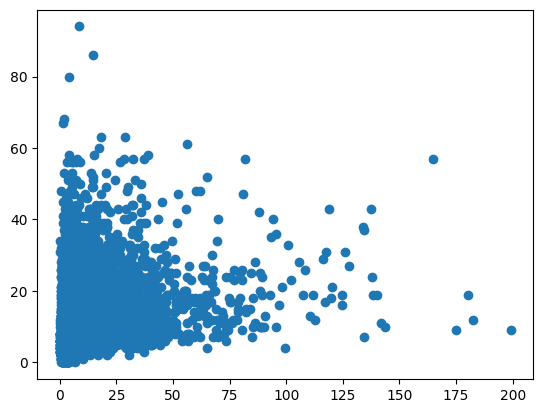

In [11]:
# Now we just produse some other plots, looking at corrolations between diferent values.
x_value = 'FFT.258Hz'
y_value = 'atmos_enviro.AE_10.0'

print('Corrilation: {}'.format(df_flat[x_value].corr(df_flat[y_value])))

plt.scatter(x=df_flat[x_value], y=df_flat[y_value])
plt.show()

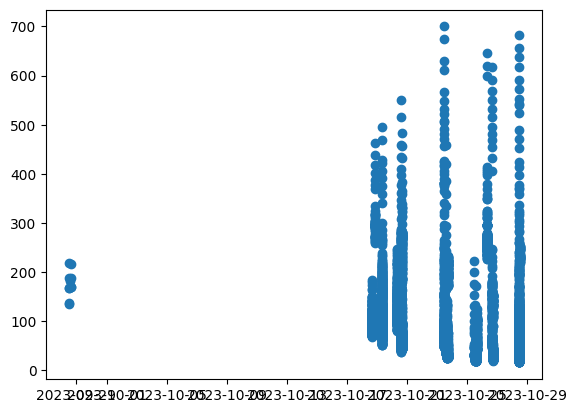

In [12]:
# simply plotting values against time.
plt.plot(df_flat['datetime'],df_flat['no2'],'o')
plt.show()

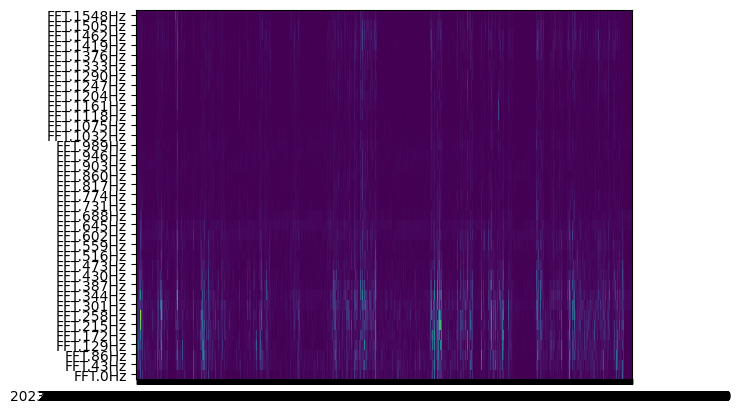

In [13]:
# produucing a spectrogram of the audio data.
bins = df_flat.filter(like='FFT').columns

plt.pcolor(df_flat.filter(like='FFT').T)
plt.yticks(np.arange(0.5, bins.size, 1), bins)
plt.xticks(np.arange(0.5, len(df_flat.index), 1), df_flat.datetime)
plt.show()

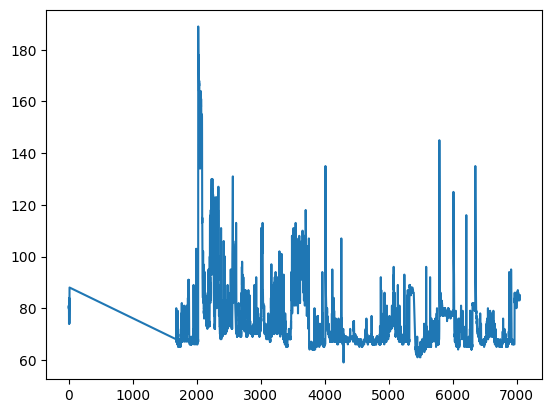

In [14]:
# plot against measurement reading rather than time. (no gaps)
plt.plot(df_flat.co)
plt.show()

In [15]:
# if we want to filter out some part of the data based on time, this is how we do it.

start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 23, 10, 55))
end_time = datetime.now(pytz.timezone('UTC'))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

In [16]:
# we can then get only those rows that are within the time range we are looking for by dooing this:
df_flat[mask]

datetime   fix  speed       angle  satellites  \
4110 2023-10-23 10:55:10+00:00  True  14.90  359.739990        13.0   
4111 2023-10-23 10:55:15+00:00  True  14.90  359.739990        14.0   
4112 2023-10-23 10:55:20+00:00  True  15.12   15.860000        14.0   
4113 2023-10-23 10:55:25+00:00  True  15.12   15.860000        14.0   
4114 2023-10-23 10:55:30+00:00  True  15.79    9.350000        14.0   
...                        ...   ...    ...         ...         ...   
7045 2023-10-28 11:51:43+00:00  True   0.17  262.839996         7.0   
7046 2023-10-28 11:51:48+00:00  True   0.44  112.489998         7.0   
7047 2023-10-28 11:51:53+00:00  True   0.44  112.489998         7.0   
7048 2023-10-28 11:51:58+00:00  True   0.29  112.489998         7.0   
7049 2023-10-28 11:52:03+00:00  True   0.29  112.489998         7.0   

      location.lat  location.long  location.alt  humidity  temp  heat_index  \
4110   5128.003906     233.012100     58.700001      72.8  15.6       15.12   
4111   5128.024414     233.008301     51.799999      72.3  15.5       14.99   
4112   5128.044922     233.002701     51.799999      72.7  15.5       15.00   
4113   5128.066895     232.994003     46.599998      73.4  15.4       14.91   
4114   5128.088867     232.984894     46.599998      74.3  15.4       14.94   
...            ...            ...           ...       ...   ...         ...   
7045   5127.503418     232.281296     68.699997      54.2  20.8       20.35   
7046   5127.502930     232.279404     68.699997      54.2  20.8       20.35   
7047   5127.502930     232.278397     68.599998      54.2  20.8       20.35   
7048   5127.502930     232.276993     68.599998      54.2  20.8       20.35   
7049   5127.502930     232.276794     68.599998      54.2  20.8       20.35   

        no2  c2h5ch    voc    co  atmos_enviro.AE_1.0  atmos_enviro.AE_2.5  \
4110  120.0   203.0  239.0  67.0                  7.0                  9.0   
4111  118.0   199.0  236.0  68.0                  9.0                 10.0   
4112  124.0   206.0  235.0  69.0                 11.0                 12.0   
4113  124.0   209.0  233.0  72.0                 11.0                 13.0   
4114  137.0   227.0  234.0  74.0                 16.0                 18.0   
...     ...     ...    ...   ...                  ...                  ...   
7045  250.0   282.0  115.0  84.0                  3.0                  3.0   
7046  251.0   279.0  115.0  83.0                  3.0                  4.0   
7047  253.0   283.0  115.0  84.0                  1.0                  3.0   
7048  253.0   285.0  115.0  85.0                  1.0                  2.0   
7049  251.0   287.0  116.0  85.0                  1.0                  3.0   

      atmos_enviro.AE_10.0  FFT.0Hz  FFT.43Hz  FFT.86Hz  FFT.129Hz  FFT.172Hz  \
4110                   9.0    27.53     49.50     72.69     110.05     101.93   
4111                  10.0    29.17     46.51     58.04      63.48      64.51   
4112                  12.0    17.58     12.51     27.71      20.57      17.82   
4113                  18.0    16.30     19.47     31.92      56.09      33.81   
4114                  26.0   121.64    129.64    110.60      90.39      96.19   
...                    ...      ...       ...       ...        ...        ...   
7045                   7.0     0.12      0.85      0.24       0.85       0.73   
7046                   8.0     0.31      0.31      0.31       1.77       2.56   
7047                   6.0     0.31      0.79      0.85       1.16       0.79   
7048                   5.0     0.79      0.06      0.18       1.10       1.04   
7049                   6.0     0.43      0.73      0.37       0.55       0.98   

      FFT.215Hz  FFT.258Hz  FFT.301Hz  FFT.344Hz  FFT.387Hz  FFT.430Hz  \
4110      53.28      73.36      76.78      28.87      40.89      43.27   
4111      79.77      90.21      61.83      71.41      40.41      19.04   
4112      40.77      29.11      44.74      49.38      13.55      10.68   
4113      56.2

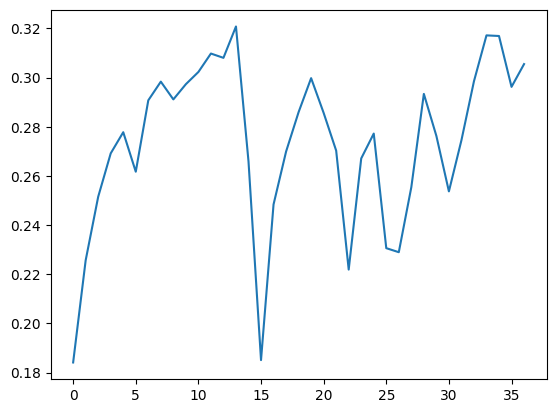

In [17]:
# foring through all the FFT bins to see if any of them corrolate well with other values.
freq=[]
corr=[]
for bin in bins:
    freq.append(bin)
    corr.append(df_flat[mask]['atmos_enviro.AE_10.0'].corr(df_flat[mask][bin]))

# results are saved to a list for that they can be plotted.
df_FFTCorrilation = pd.DataFrame({'Frequency':freq, 'Corrilation':corr})
df_FFTCorrilation

plt.plot(df_FFTCorrilation['Corrilation'])
plt.show()

Corrilation: 0.7706140374525412


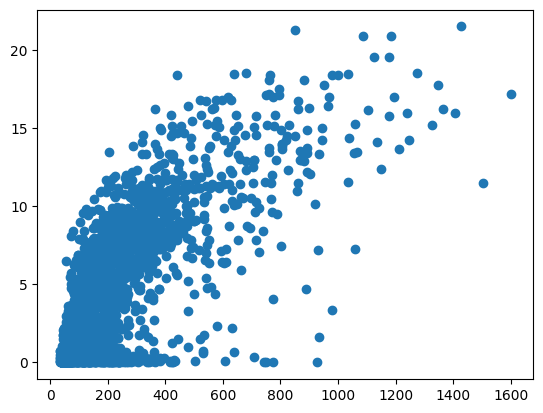

In [18]:
# more corralation stuff
print('Corrilation: {}'.format(df_flat.filter(like='FFT').sum(axis='columns').corr(df_flat[mask]['speed'])))

plt.scatter(df_flat[mask].filter(like='FFT').sum(axis='columns'), df_flat[mask]['speed'])
plt.show()